# 🧬 **Yapay Zeka Destekli İlaç Keşfi: ABL1 Hedefli Molekül Üretimi**

Bu proje, **Kronik Miyeloid Lösemi (CML)** tedavisinde kritik bir hedef olan **ABL1** proteinini baskılayabilecek (inhibitör) yeni ilaç aday moleküllerini **Generative AI (Üretken Yapay Zeka)** kullanarak tasarlamayı amaçlamaktadır.

---

### 🚀 **Proje Akışı:**
1.  **Biyoinformatik:** NCBI'dan hedef protein sekansının çekilmesi.
2.  **Veri Madenciliği:** ChEMBL veritabanından bu hedefe etki eden ilaçların bulunması.
3.  **Keminformatik:** RDKit ile moleküllerin temizlenmesi ve SMILES formatına çevrilmesi.
4.  **Deep Learning:** PyTorch ile LSTM tabanlı bir dil modeli eğitilmesi.
5.  **De Novo Tasarım:** Eğitilen model ile tamamen yeni moleküllerin üretilmesi.

### 🛠️ **Kullanılan Kütüphaneler:**
<span style="background-color: #f1c40f; color: black; padding: 4px 8px; border-radius: 4px; font-weight: bold; margin-right:5px;">BioPython</span>
<span style="background-color: #008080; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold; margin-right:5px;">ChEMBL Web Resource</span>
<span style="background-color: #3498db; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold; margin-right:5px;">RDKit</span>
<span style="background-color: #e74c3c; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold; margin-right:5px;">PyTorch</span>

In [2]:
!pip install biopython
!pip install chembl-webresource-client
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 62.5 MB/s eta 0:00:00


In [3]:
# Gerekli kütüphaneler: biopython, chembl_webresource_client, rdkit
from Bio import Entrez, SeqIO
import time
from chembl_webresource_client.new_client import new_client

## 1️⃣ **Biyoinformatik Veri Toplama: ABL1 Proteini**
<div style="background-color: #e8f6f3; padding: 15px; border-left: 5px solid #1abc9c; border-radius: 5px;">
<strong>Hedef:</strong> NCBI veritabanını kullanarak Lösemi ile ilişkili <code>NP_005148</code> kodlu ABL1 proteininin FASTA sekansını çekmek.
</div>

In [4]:
Entrez.email = "240542017@firat.edu.tr"
handle = Entrez.efetch(db="protein", id="NP_005148", rettype="fasta", retmode="text")
target_sequence = handle.read()
print("Hedef Protein İndirildi:", target_sequence[:50])

Hedef Protein İndirildi: >NP_005148.2 tyrosine-protein kinase ABL1 isoform 


In [5]:
with open("abl1_hedef_protein.fasta", "w") as f:
    f.write(target_sequence)

print("Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.")

Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.


### 🧬 FASTA Dosyası Temizliği
Biopython kütüphanesindeki <span style="background-color: #2c3e50; color:white; padding: 2px 5px; border-radius: 3px;">**SeqIO**</span> modülü kullanılarak mükerrer kayıtlar temizlenir.

In [6]:
start = time.time()
seen = []
records = []
for record in SeqIO.parse("abl1_hedef_protein.fasta", "fasta"):
    if(str(record.seq) not in seen):
        seen.append(str(record.seq))
        records.append(record)
#Fasta dosyasını yeniden yazıyoruz.
SeqIO.write(records, "abl1_hedef_protein_tekrarsız.fasta", "fasta")
end = time.time()
print(f"Çalışma Süresi {(end- start)} saniye \n Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi")

Çalışma Süresi 0.0011074542999267578 saniye 
 Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi


## 2️⃣ **İlaç Verisi Madenciliği: ChEMBL Veritabanı**
<div style="background-color: #fcf3cf; padding: 15px; border-left: 5px solid #f1c40f; border-radius: 5px;">
<strong>Amaç:</strong> ChEMBL veritabanına bağlanarak <strong>Homo sapiens</strong> organizmasındaki <strong>ABL1</strong> hedefine karşı aktivite gösteren (IC50 değeri olan) molekülleri çekmek.
</div>

In [7]:
# 2. ChEMBL'den Bu Hedefe Uygun İlaçları Bul
target = new_client.target
target_query = target.filter(target_synonym__icontains='ABL1').filter(target_organism__icontains='Homo sapiens')
target_id = target_query[0]['target_chembl_id']

activity = new_client.activity
res = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")

# İlaçların SMILES kodlarını topla
smiles_list = [x['canonical_smiles'] for x in res if x['canonical_smiles']]
print(f"{len(smiles_list)} adet potansiyel molekül bulundu.")

5287 adet potansiyel molekül bulundu.


## 3️⃣ **Keminformatik: Veri Temizliği ve Standardizasyon (RDKit)**
Kimyasal moleküllerin metin temsili olan SMILES kodlarının standart hale getirilmesi (Canonicalization) modelin öğrenme başarısı için kritiktir.

* Veriler önce bir csv dosyasında toplanır
* <span style="background-color: #3498db; color: white; padding: 2px 5px; border-radius: 3px;">RDKit</span> kullanılarak geçersiz moleküller elenir.
* Canonical SMILES formatına çevrilerek mükerrer kayıtlar silinir.

In [8]:
from rdkit import Chem
import pandas as pd

# 1. Listeyi DataFrame'e (Tabloya) çevir
df = pd.DataFrame(smiles_list, columns=['SMILES'])

# 2. CSV dosyası olarak kaydet
df.to_csv('abl1_ilac_verisi.csv', index=False)

print(f"Başarılı! {len(df)} adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.")

Başarılı! 5287 adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.


In [9]:
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None # Geçersiz SMILES ise boş dön
    except:
        return None

# 2. İşlemi Uygula
print(f"Başlangıçtaki veri sayısı: {len(df)}")

# 'Canonical_SMILES' adında yeni bir sütun oluşturuyoruz
df['Canonical_SMILES'] = df['SMILES'].apply(canonicalize_smiles)

# 3. Geçersiz (None) olanları at (Bazen veritabanında hatalı kayıtlar olabilir)
df = df.dropna(subset=['Canonical_SMILES'])

# 4. ŞİMDİ kopyaları sil (Canonical sütununa göre)
df_clean = df.drop_duplicates(subset=['Canonical_SMILES'])

print(f"Temizlendikten sonraki veri sayısı: {len(df_clean)}")

# Temiz veriyi kullanalım
df_clean.to_csv('abl1_ilac_verisi_clean.csv', index=False)

Başlangıçtaki veri sayısı: 5287
Temizlendikten sonraki veri sayısı: 2851


In [10]:
df_clean

,SMILES,Canonical_SMILES
0,COc1ccc(-c2[nH]nc3c2C(=O)c2ccccc2-3)cc1,COc1ccc(-c2[nH]nc3c2C(=O)c2ccccc2-3)cc1
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
5,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
7,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...
...,...,...
5282,CCC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5...,CCC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5...
5283,CC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5)...,CC(NC(=O)c1ccc(C2CC2)c(-c2ccc3nc(Nc4cnn(C5CC5)...
5284,CC(NC(=O)c1cccc(C(F)(F)F)c1)c1ccc(C2CC2)c(-c2c...,CC(NC(=O)c1cccc(C(F)(F)F)c1)c1ccc(C2CC2)c(-c2c...
5285,CCc1ccc(C(C)NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1ccc...,CCc1ccc(C(C)NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1ccc...


## 4️⃣ **Deep Learning Hazırlığı: Tokenizasyon**
Yapay zeka modelleri metinleri doğrudan anlayamaz. SMILES dizilerini (örn: `CC(=O)C`) modelin anlayacağı sayılara (vektörlere) çevirmemiz gerekir.

* **Token:** Molekülün her bir parçası (C, =, (, ), O).
* **Vocabulary:** Tüm veri setindeki benzersiz karakterlerin listesi.

In [11]:
import re

def tokenize_smiles(smiles):
    pattern = r"(\[[^\[\]]{1,6}\])"
    tokens = re.split(pattern, smiles)
    result = []
    for token in tokens:
        if token.startswith('['):
            result.append(token)
        else:
            result.extend(list(token))
    return result

# Example usage
print(tokenize_smiles('CC(=O)OC1=CC=CC=C1C(=O)O'))

['C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O']


In [12]:
# Tüm veri setindeki SMILES'ları tarayıp benzersiz tokenleri bulalım
all_smiles = df_clean['Canonical_SMILES'].tolist()
unique_tokens = set()

for smile in all_smiles:
    tokens = tokenize_smiles(smile)
    unique_tokens.update(tokens)

# Özel tokenleri ekleyelim
# <PAD>: Dolgu (0), <SOS>: Başlangıç, <EOS>: Bitiş
vocab = sorted(list(unique_tokens))
vocab = ['<PAD>', '<SOS>', '<EOS>'] + vocab

# Token -> ID (stoi) ve ID -> Token (itos) sözlüklerini kuralım
stoi = { token:i for i, token in enumerate(vocab) }
itos = { i:token for i, token in enumerate(vocab) }

print(f"Toplam Benzersiz Token Sayısı (Vocab Size): {len(vocab)}")
print("Örnek Token ID'leri:", list(stoi.items())[:10])

Toplam Benzersiz Token Sayısı (Vocab Size): 45
Örnek Token ID'leri: [('<PAD>', 0), ('<SOS>', 1), ('<EOS>', 2), ('#', 3), ('(', 4), (')', 5), ('-', 6), ('.', 7), ('/', 8), ('1', 9)]


### 🔢 Vektörleştirme ve PyTorch Dataset Oluşturma
Molekülleri sayısal tensörlere dönüştürüp, modele beslemek için `Dataset` ve `DataLoader` yapısını kuruyoruz.

In [13]:
import torch
import numpy as np

# Maksimum molekül uzunluğunu bulalım (Padding için gerekli)
max_len = max([len(tokenize_smiles(s)) for s in all_smiles]) + 2 # +2 SOS ve EOS için
print(f"En uzun molekül uzunluğu: {max_len}")

def smile_to_vector(smile, vocab_stoi, max_len):
    tokens = tokenize_smiles(smile)
    # Başına <SOS>, sonuna <EOS> ekle
    vector = [vocab_stoi['<SOS>']] + [vocab_stoi[t] for t in tokens] + [vocab_stoi['<EOS>']]

    # Padding (Geri kalan kısmı <PAD> yani 0 ile doldur)
    padding = [vocab_stoi['<PAD>']] * (max_len - len(vector))
    return vector + padding

# Tüm veri setini vektörleştirelim
X_data = []
for smile in all_smiles:
    vec = smile_to_vector(smile, stoi, max_len)
    X_data.append(vec)

# Tensor'a çevirelim (PyTorch formatı)
X_tensor = torch.tensor(X_data, dtype=torch.long)
print(f"Veri Seti Boyutu: {X_tensor.shape}") # (2851, max_len) olmalı

En uzun molekül uzunluğu: 210
Veri Seti Boyutu: torch.Size([2851, 210])


In [14]:
from torch.utils.data import Dataset, DataLoader

class DrugDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Girdi (Input): Molekülün başından sonuna kadar (son karakter hariç)
        # Hedef (Target): Molekülün 2. karakterinden sonuna kadar (bir adım kaydırılmış)
        # Model 'A'yı görünce 'B'yi tahmin etmeye çalışacak.

        full_seq = self.data[idx]
        x = full_seq[:-1] # Girdi
        y = full_seq[1:]  # Hedef (Sonraki karakter)
        return x, y

# Dataset ve DataLoader oluşturma
batch_size = 32 # T4 GPU için uygun bir boyut
dataset = DrugDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Test edelim
sample_x, sample_y = next(iter(dataloader))
print("Girdi (X) Boyutu:", sample_x.shape)
print("Hedef (Y) Boyutu:", sample_y.shape)

Girdi (X) Boyutu: torch.Size([32, 209])
Hedef (Y) Boyutu: torch.Size([32, 209])


In [15]:
import torch.nn as nn

class MoleculeGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(MoleculeGenerator, self).__init__()

        # 1. Embedding: Sayıları vektörlere çevirir (Örn: 5 -> [0.1, -0.5, ...])
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # 2. LSTM: Dizideki ilişkiyi öğrenir
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # 3. Linear: Sonraki karakterin olasılığını hesaplar
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embed = self.embedding(x)

        # out shape: (batch_size, seq_len, hidden_size)
        out, (ht, ct) = self.lstm(embed, hidden)

        # output shape: (batch_size, seq_len, vocab_size)
        output = self.fc(out)
        return output, (ht, ct)

# Model Parametreleri
VOCAB_SIZE = len(vocab)
EMBED_SIZE = 128   # Her token ne kadar detaylı temsil edilsin?
HIDDEN_SIZE = 256  # Modelin hafıza kapasitesi
NUM_LAYERS = 2     # Kaç katmanlı LSTM?

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MoleculeGenerator(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)

print(model)
print(f"Model {device} üzerinde çalışacak.")

MoleculeGenerator(
  (embedding): Embedding(45, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=45, bias=True)
)
Model cuda üzerinde çalışacak.


In [ ]:
import time
import torch.optim as optim
import torch.nn as nn

# Hiperparametreler ve Ayarlar
LEARNING_RATE = 0.001
EPOCHS = 1000

# Eğer daha önce tanımlanmadıysa tekrar tanımlayalım
criterion = nn.CrossEntropyLoss(ignore_index=stoi['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, dataloader, epochs):
    model.train() # Başlangıçta eğitim modu
    loss_history = []
    print(f"Eğitim Başlıyor... ({device})")

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0

        for batch_idx, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, _ = model(x)

            loss = criterion(output.view(-1, VOCAB_SIZE), y.view(-1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        elapsed = time.time() - start_time

        if (epoch+1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Süre: {elapsed:.1f}sn")

            # Her 2 epochta bir örnek üretip gelişimini görelim (Sıklığı artırdım)
            if (epoch+1) % 2 == 0:
                print("   -> Örnek üretiliyor...")

                # 1. Örnek Üret (Bu işlem model.eval() yapar)
                test_smiles = generate_molecule(model, start_str="C", temperature=0.8)
                print(f"   -> Sonuç: {test_smiles}")

                # 2. KRİTİK DÜZELTME: Modeli tekrar eğitim moduna al!
                model.train()
                # ^^^ BU SATIR EKSİKTİ ^^^

    return loss_history

# Eğitimi tekrar başlat (Modelin kaldığı yerden devam eder ama temiz olsun dersen modeli tekrar baştan tanımlayabilirsin)
loss_history = train(model, dataloader, EPOCHS)

# Modeli Kaydet
torch.save(model.state_dict(), "oncomind_model.pth")
print("Model başarıyla kaydedildi!")

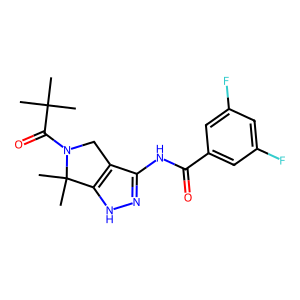

In [21]:
from  rdkit  import  Chem
from  rdkit.Chem  import  Draw

mol  =  Chem.MolFromSmiles("CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]c2C1(C)C")
Draw.MolToImage(mol)

In [18]:
def generate_molecule(model, start_str="C", max_length=100, temperature=1.0):
    model.eval() # Değerlendirme modu

    # Başlangıç karakterini vektöre çevir
    input_seq = [stoi['<SOS>']] + [stoi[c] for c in start_str]
    input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    generated_str = start_str
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(input_tensor, hidden)

            # Son karakterin tahminini al
            last_token_logits = output[0, -1, :] / temperature
            probs = torch.nn.functional.softmax(last_token_logits, dim=0)

            # Olasılıklara göre bir sonraki karakteri seç
            next_token_idx = torch.multinomial(probs, 1).item()

            if next_token_idx == stoi['<EOS>']:
                break

            next_char = itos[next_token_idx]
            generated_str += next_char

            # Yeni girdiyi güncelle
            input_tensor = torch.tensor([[next_token_idx]], dtype=torch.long).to(device)

    return generated_str

generated_molecule = generate_molecule(model, start_str="C", temperature=0.8)
print("Üretilen Örnek:", generated_molecule)

Üretilen Örnek: C)lCs[n+]F[C@H]FoI[C@H]2([S+]Cr3[C@@]sN[S+][Si]oB4[C-][N+]l[n+])


In [20]:
# Modelin ürettiği çıktıyı analiz etme ve eleme kısmı (Organ yetmezliği kısıtı)
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def check_drug_quality(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return False

    # 1. QED (Quantitative Estimation of Drug-likeness)
    # Bu skor ilacın genel olarak vücutta emilip emilemeyeceğini tahmin eder.
    qed_score = QED.qed(mol)

    # 2. Moleküler Ağırlık (Çok ağırsa böbreklerden atılamaz)
    mw = Descriptors.MolWt(mol)

    # Filtre: İlaç benzeri olsun VE çok ağır olmasın (Basit bir toksisite önlemi)
    if qed_score > 0.5 and mw < 500:
        return True, f"Molekül uygun. QED: {qed_score:.2f}, MW: {mw:.1f}"
    else:
        return False, "Uygunsuz."

# Örnek Kullanım
generated_molecule = "CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]c2C1(C)C" # (Imatinib benzeri bir yapı)
is_good, reason = check_drug_quality(generated_molecule)
print(reason)

Molekül uygun. QED: 0.84, MW: 376.4


In [19]:
import torch

# 1. Model Mimarisini Tekrar Tanımla (Eğitimdeki parametrelerin aynısı olmalı!)
# Eğer eğitimde hidden_size=256 kullandıysan burada da 256 olmalı.
VOCAB_SIZE = len(vocab) # vocab listenizin hafızada olduğunu varsayıyorum
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Boş bir model iskeleti oluştur
loaded_model = MoleculeGenerator(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)

# 3. .pth Dosyasını Yükle
# map_location, GPU'da eğitilen modeli CPU'da (veya tam tersi) açarken hata almanı önler.
model_path = "oncomind_model.pth" # Dosya adın neyse
checkpoint = torch.load(model_path, map_location=device)

# 4. Ağırlıkları iskelete giydir
loaded_model.load_state_dict(checkpoint)

# 5. Modeli Değerlendirme Moduna Al (Drop-out vb. kapatmak için)
loaded_model.eval()

print("Model başarıyla dosyadan yüklendi!")

# 6. Artık 'loaded_model' değişkenini fonksiyona gönderebilirsin
new_molecule = generate_molecule(loaded_model, start_str="C", temperature=0.8)
print("Dosyadan yüklenen model ile üretilen:", new_molecule)

Model başarıyla dosyadan yüklendi!
Dosyadan yüklenen model ile üretilen: CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]c2C1(C)C
